# Multi Order Coverage data structure to plan multi-messenger observations

Giuseppe Greco¹

1. INFN, Sezione de Perugia, 1-06123 Perugia, Italy


This notebook is a tutorial associated to the article [Multi Order Coverage data structure to plan
multi-messenger observations](https://www.sciencedirect.com/science/article/pii/S2213133722000026?via%3Dihub).

***

We will first explore Multi-Order Coverage (MOC) data structure manipultation, then we will see how astroplan and Space-Time Multi Order Coverage (STMOC) can be combined. The final step is a concrete example illustrating how STMOCS can be build in a few seconds to plan observations from three ground observatories of the full sky localisation produced after detection of a gravitational wave.

## Setting the notebook


In [1]:
# General use python packages
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
from IPython import display

# Healpix and MOC packages
from mocpy import MOC, STMOC
from cdshealpix import healpix_to_skycoord

# Common astronomy packages
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.table import QTable
from astropy.utils.data import download_file
from astropy.io import fits

# Visualisation widget
import ipyaladin as ipyal

# Library to bluid observation plan
from astroplan import Observer

# Communication between this notebook and other astro softwares
from astropy.samp import SAMPIntegratedClient

In [2]:
# define a path to store data
path = Path.cwd() / "Data/Multi-order-coverage-to-plan-MMA/"
path.mkdir(parents=True, exist_ok=True)

**SAMP function**
We create a function based on [SAMP](https://docs.astropy.org/en/stable/samp/index.html) (Simple Application Messaging Protocol) to see the MOC visibility map in an Aladin session. 

In [3]:
def send_via_samp(url="", filename=""):
    """Sending MOC file over SAMP.

    Parameters
    ----------
    url : str
        URL to the file

    filename : str
        human - readable name for the MOC file

    Returns
    -------
    a MOC file is transmitted in tools in which SAMP Hub is running
    """

    client = SAMPIntegratedClient()
    client.connect()

    params = {}
    params["url"] = str(url / filename)  # has to be converted to string for marshall
    print(params["url"])
    params["name"] = filename

    message = {}
    message["samp.mtype"] = "coverage.load.moc.fits"
    message["samp.params"] = params

    client.notify_all(message)
    client.disconnect()


## Manipulating MOCs


In this first section, we build an elementary MOC, describe essential algorithms and perform basic tests.

First, we create a MOC region with the HEALPix index = 652 at order = 4 applying the method [from_healpix_cells](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_healpix_cells) from mocpy.

In [4]:
ipix = np.array([652], dtype="uint64")
depth = np.array([4], dtype="uint8")

moc_test = MOC.from_healpix_cells(ipix, depth)
print(type(moc_test))
moc_test

<class 'mocpy.moc.moc.MOC'>


[[734086739261390848 735212639168233472]]

Then, we write the MOC region in an external file named **TEST.fits** serialized in a FITS format.

In [5]:
moc_test.write(path.parent / "TEST.fits", format="fits", overwrite=True)

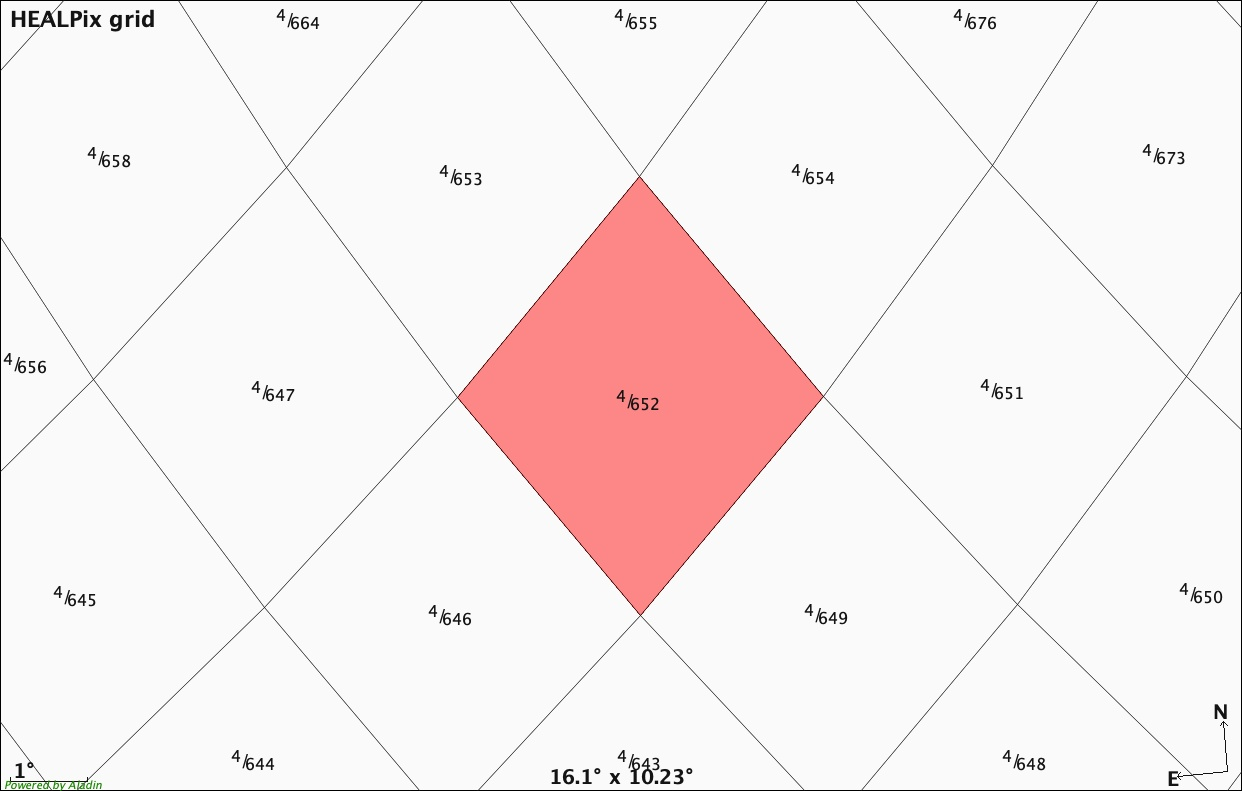

In [6]:
display.Image(path.parent / "images/MOC-to-plan-MMA/Fig1.jpg")

**Figure 1.** HEALPix grid at order = 4. In red, the MOC region with HEALPix index = 652. This represents the MOC we created.

Now, we read the MOC file `TEST.fits` and we find the MOC order: the depth of the smallest HEALPix cells. Of course, we will find an order = 4 as set when we created the MOC.

In [7]:
# Read  MOC map.
moc = MOC.from_fits(path / "TEST.fits")

# Find MOC order
moc_order = moc.max_order
print("moc_order =", moc_order)

moc_order = 4


Here, we serialize the MOC from fits to json/dictionary with the keys and values representing the orders and the pixel indices, respectively. Of course, in our case we will find a dictionary with key = 4 and value = 652, the values used in the original MOC creation.

In [8]:
# Serialize the MOC from fits to json/dict.
moc_json = moc.serialize(format="json")
moc_json

{'4': [652]}

Next, we want to increase the MOC order from 4 to 5 and to calculate the associated HEALPix indexes at that order. MOC uses the [NESTED](https://healpix.jpl.nasa.gov/html/intronode4.htm) numbering scheme. Thus, each spatial MOC cell can be
stored as one single  interval ranging from $[npix \times 4^{(max\_order - order)}]$ to 
$[(npix+1) \times 4^{(max\_order - order)}-1] $.

If you want to play around parameters here, you need to set a new MOC order greater than or equal to the order defined in the original MOC. 

In [9]:
# Sets a new MOC order: new MOC order >= original MOC order.
new_order = 5

# Init. a list of HEALPix indices.
healpix_indices = []

# Read MOC JSON file.
for key, value in moc_json.items():
    order = int(key)

    # Flatten cells.
    for npix in value:
        first_index = npix * 4 ** (new_order - moc_order)
        last_index = (npix + 1) * 4 ** (new_order - moc_order) - 1

        # Resulting list of flatten cells.
        for healpix_index in np.arange(first_index, last_index + 1):
            healpix_indices.append(healpix_index)

healpix_indices

[2608, 2609, 2610, 2611]

**Figure 2** shows the  HEALPix grid at the order = 5. In red, the selected MOC region is depicted. You can visualize the HEALPix indices: 2608, 2609, 2610, 2611 as calculated in our code.
When the entire collection of cells in a MOC map is 
computed at the same
order, we can invoke the method [healpix to skycoord](https://cds-astro.github.io/cds-healpix-python/stubs/cdshealpix.nested.healpix_to_skycoord.html#cdshealpix.nested.healpix_to_skycoord) from the `cdshealpix` python module.

This method converts HEALPix indices to celestial coordinates.
The input is a 1-D array of HEALPix indices and the resulting celestial coordinates
are returned in a [SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#:~:text=High%2Dlevel%20object%20providing%20a,coordinate%20values%20with%20unambiguous%20units) high-level object as defined in astropy.
They are the sky coordinates of the center of the HEALPix cells and marked with a circle in **Figure 2**.

In [10]:
skycoords = healpix_to_skycoord(healpix_indices, new_order)
skycoords

<SkyCoord (ICRS): (ra, dec) in deg
    [(202.5    , 31.38816646), (203.90625, 32.7971683 ),
     (201.09375, 32.7971683 ), (202.5    , 34.22886633)]>

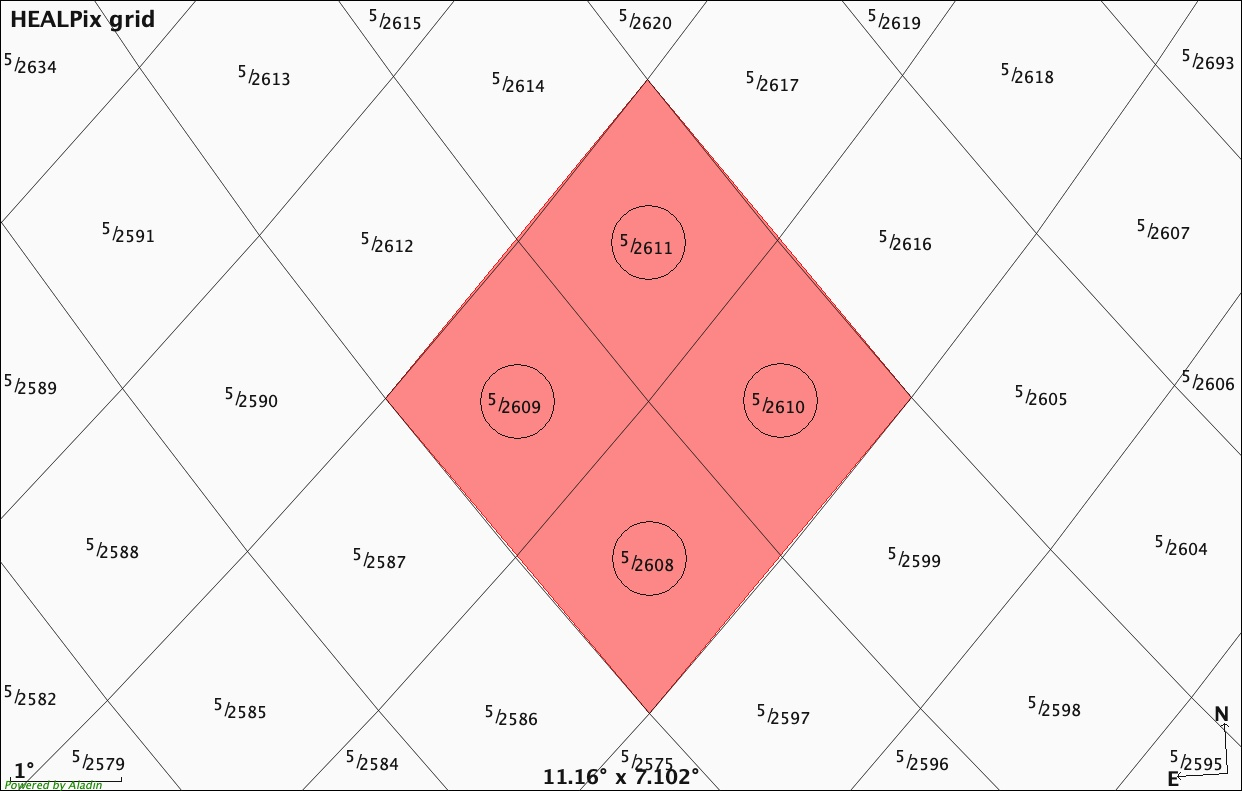

In [11]:
display.Image(path.parent / "images/MOC-to-plan-MMA/Fig2.jpg")

**Figure 2.**. HEALPix grid at order = 5 with the HEALPix indices, 2608, 2609, 2610, 2611. They are the same indices as provided by our code. The sky coordinates of the center of the HEALPix cells are marked with circles. The sky coordinates are computed by the [healpix to skycoord](https://cds-astro.github.io/cds-healpix-python/stubs/cdshealpix.nested.healpix_to_skycoord.html#cdshealpix.nested.healpix_to_skycoord) method in cdshealpix.

You can interactively visualize the results with the following Aladin widget. To see the HealPix grid, select it in the `manage layers` <img src="https://github.com/ggreco77/Tutotest/blob/main/images/ipyaladin_layer.png?raw=true" alt="the Layer Button" style="width:30px; display: inline-block;"/> menu.

In [12]:
aladin = ipyal.Aladin(target="13:29:59.9947023, +32:47:54.490452", fov=35)
aladin

Aladin(fov=35.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…

A MOC map can also be added to the Aladin widget by adding it to the variable `aladin`:

In [13]:
moc_test = {"5": [2608, 2609, 2610, 2611]}
aladin.add_moc_from_dict(
    moc_test,
    {"color": "red", "opacity": 0.4, "adaptativeDisplay": False, "name": "TEST"},
)

## Astroplan

In this second section, we cover the use of [astroplan](https://astroplan.readthedocs.io/en/latest/index.html) a python library useful for observation planning and scheduling.

First, we want to define the airmass in each HEALPix index using the astroplan module. In particular, we define the airmass in the Haleakala site  at 2019-04-25 14:18:05.018 UTC.

In [14]:
# Set Observer: Haleakala.
haleakala = Observer.at_site("haleakala")

# Set observational time.
start_time = Time("2019-04-25 12:30:00")

haleakala

<Observer: name='haleakala',
    location (lon, lat, el)=(-156.169 deg, 20.71552 deg, 3047.9999999999245 m),
    timezone=<UTC>>

Haleakala info from Observer class in astroplan.

In [15]:
print(
    f"We could apply any of the methods listed here to the object haleakea {dir(haleakala)}"
)

We could apply any of the methods listed here to the object haleakea ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_altitude_trig', '_calc_riseset', '_calc_transit', '_determine_which_event', '_horiz_cross', '_is_broadcastable', '_preprocess_inputs', '_two_point_interp', 'altaz', 'astropy_time_to_datetime', 'at_site', 'datetime_to_astropy_time', 'is_night', 'local_sidereal_time', 'location', 'midnight', 'moon_altaz', 'moon_illumination', 'moon_phase', 'moon_rise_time', 'moon_set_time', 'name', 'noon', 'parallactic_angle', 'pressure', 'relative_humidity', 'sun_altaz', 'sun_rise_time', 'sun_set_time', 'target_hour_angle', 'target_is_up', 'target_meridian_antitransit_time', 'target_meridian_tra

Does the time we set correspond to night time at Haleakala? You can answer it using [is_night](https://astroplan.readthedocs.io/en/latest/api/astroplan.Observer.html#astroplan.Observer.is_night) method and setting the astronomical twilight.

In [16]:
# Check if it is night in Haleakala at defined time:
# -18 degree horizon (evening astronomical twilight).
night = haleakala.is_night(start_time, horizon=-18 * u.deg)
print("Is it night?", night)

Is it night? True


We have all needed information to calculate the airmass at the sky coordinates determined in the first section.

In [17]:
# Airmass calculation
airmass_values = haleakala.altaz(start_time, skycoords).secz

for airmass_value, skycoord in zip(airmass_values, skycoords):
    print(f"airmass: {airmass_value.round(2)} {skycoord} ")

airmass: 1.28 <SkyCoord (ICRS): (ra, dec) in deg
    (202.5, 31.38816646)> 
airmass: 1.27 <SkyCoord (ICRS): (ra, dec) in deg
    (203.90625, 32.7971683)> 
airmass: 1.31 <SkyCoord (ICRS): (ra, dec) in deg
    (201.09375, 32.7971683)> 
airmass: 1.29 <SkyCoord (ICRS): (ra, dec) in deg
    (202.5, 34.22886633)> 


To only select sky area with airmass < 1.30, we create a new MOC with those sky coordinates. We will call it `MOC_observability`. 

It can be useful to create an astropy table with skycoords and airmass_values as columns. Then we filter the airmass_values column from 1.00 to 1.30. 

In [18]:
table = QTable([skycoords, airmass_values], names=["skycoords", "airmass_value"])

# Mask table with selected airmass values.
observability_table = table[
    (table["airmass_value"] >= 1.0) & (table["airmass_value"] <= 1.3)
]

## Combining astroplan and STMOC

We invoke [from_skycoords](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_skycoords) method in mocpy and write the MOC observability in an output file named **moc_observability_haleakala**.

In [19]:
# MOC from  sky coordinates
moc_observability_haleakala = MOC.from_skycoords(
    observability_table["skycoords"], new_order
)

# Write MOC in fits
moc_observability_haleakala.write(
    path / "moc_observability_haleakala", format="fits", overwrite=True
)

The MOC observability is shown in green in **Figure 3** over the original MOC. The HEALPix index = 2610 at order = 5 is not considered in the MOC visibility at the coordinates RA = 201.09375 $^\circ$, DEC = 32.7971683 $^\circ$. This is because its associated airmass value = 1.31 is outside the airmass range we selected to create the MOC visibility from Haleakala.

In [20]:
# Sky position of HEALPix index = 2610 at order = 5.
skycoord = healpix_to_skycoord(2610, 5)
skycoord

<SkyCoord (ICRS): (ra, dec) in deg
    [(201.09375, 32.7971683)]>

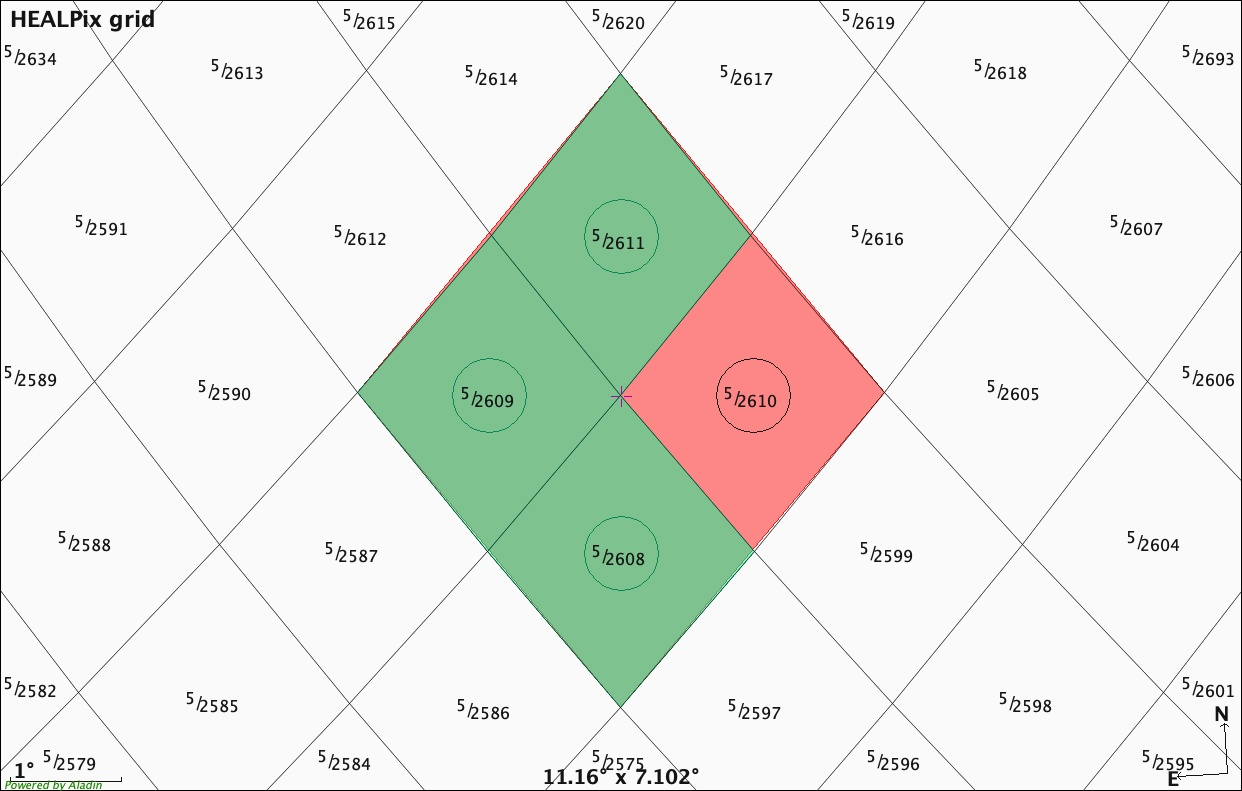

In [21]:
display.Image(path.parent / "images/MOC-to-plan-MMA/Fig3.jpg")

**Figure 3**. In green, the MOC visibility from the Haleakala site with airmass ranges from 1.00 to 1.30 over the original MOC area in red. For an interactive visualization, you can run the code below and use the Aladin widget initialized at the beginning of the tutorial.

In [22]:
moc_obsevability = {"5": [2608, 2609, 2611]}
aladin.add_moc_from_dict(
    moc_obsevability,
    {
        "color": "green",
        "opacity": 0.7,
        "adaptativeDisplay": False,
        "name": "MOC observability",
    },
)

### Adding temporal information to an (Observability) MOC

The ability to transform any spatial MOC generated from telescope footprints, image surveys, catalogues, gravitational-wave sky localizations, MOC visibility *etc.* into spatial and temporal MOC (STMOC) offers several interoperable approaches. In the next sections, we will discuss how to filter candidate transients.

To encode temporal information in a space (observability) MOC, we apply the method [from_spatial_coverages](https://cds-astro.github.io/mocpy/stubs/mocpy.STMOC.html#mocpy.STMOC.from_spatial_coverages) from mocpy. We assume an exposure time of 10 minutes: from 2019-04-25 12:30:00 to 2019-04-25 12:40:00.

In [23]:
# Create a Space and Time MOC from a space MOC.
space_time_moc_obs = STMOC.from_spatial_coverages(
    Time(["2019-04-25 12:30:00"]),
    Time(["2019-04-25 12:40:00"]),
    [moc_observability_haleakala],
)

# Write space and time MOC
space_time_moc_obs.write(path / "space_time_moc_obs", overwrite=True)

**Filtering transient candidates**

To filter transient candidates *in space and in time* simultaneously, we use the [contains](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.contains) method in mocpy. It returns a boolean mask array of the positions lying inside (or outside) the MOC instance. Good performances are obtained thanks to the core functions written in Rust programming language.  

We consider two transients at sky positions of
-  transient1: (RA = 202.49997 $^\circ$, DEC = 32.79846 $^\circ$) observed at UTC time 2019-04-25T12:33:00
-  transient2: (RA = 202.69392 $^\circ$, DEC = 34.02011 $^\circ$) observed at UTC time 2019-04-25T12:50:00

Both candidate transients fall inside our MOC region but only the first one is consistent with the exposure time of that region, see next cells: 

In [24]:
# An astropy table with the 2 transients is created.
transient_tb = QTable()

# ID candidate transients
transient_tb["ID"] = ["transient1", "transient2"]

# Transient positions
transient_tb["ra"] = [202.49997, 202.69392] * u.deg
transient_tb["dec"] = [32.79846, 34.02011] * u.deg

# Transient time observations
transient_tb["time"] = Time(["2019-04-25T12:33:00", "2019-04-25T13:45:00"])

print(transient_tb)

    ID         ra      dec              time         
              deg      deg                           
---------- --------- -------- -----------------------
transient1 202.49997 32.79846 2019-04-25T12:33:00.000
transient2 202.69392 34.02011 2019-04-25T13:45:00.000


In [25]:
# Filtering transients in space and time.
space_time_moc_obs.contains(
    transient_tb["time"], transient_tb["ra"], transient_tb["dec"]
)

array([ True, False])

As expected,  the boolean mask returns **True** only for the transient1.

## Concrete example : planning observations for a GW follow up

Here we describe the essential steps to delimit portions of a MOC coverage that are observable from a specific astronomical site within a fixed time interval and a defined range of airmass values. We start with the 90% credible region of the gravitational-wave event GW190425. The credible region is encoded in a MOC data structure. In order to show the potential of MOCs to manage complex and irregular sky areas, the 90% credible region of GW190425 is prepocessed as discussed in **Sections 4.2 and 4.3**.
The MOC region is accessible from the link [here](https://github.com/ggreco77/MOC-to-plan-MMA/blob/main/data/processed_moc_skymap.fits?raw=true). 
All steps are shown in the [video tutorial](https://virgo.pg.infn.it/sites/virgo.pg.infn.it/files/mm/tuto_A_C_mid.mp4) focusing in the main Aladin graphical user interface. 

For running the code, we consider the merger time of GW190425 from the image's header.

In [26]:
# Download the initial (BAYESTAR)sky map of GW190425 from GraceDB.

bayesian = download_file(
    "https://gracedb.ligo.org/api/superevents/S190425z/files/bayestar.fits.gz,0",
    cache=True,
)

In [27]:
# Get merger time from image's header.
hdul = fits.open(bayesian)
merger_time = Time(hdul[1].header["DATE-OBS"])

print("The merger time is", merger_time)

The merger time is 2019-04-25T08:18:05.018


In [28]:
# Define an observatory from the astroplan list
observatory_name = "haleakala"

In [29]:
# Define observatory in the astroplan Observer class
observatory_astroplan_observer = Observer.at_site(observatory_name)

In [30]:
observatory_astroplan_observer

<Observer: name='haleakala',
    location (lon, lat, el)=(-156.169 deg, 20.71552 deg, 3047.9999999999245 m),
    timezone=<UTC>>

In [31]:
# Check if it is night in your Observatory at the merger time:
# -18 degree horizon (evening astronomical twilight).
night = observatory_astroplan_observer.is_night(merger_time, horizon=-18 * u.deg)

In [32]:
print(f"Is night in {observatory_name} ?", night)

Is night in haleakala ? True


If it is night in your observatory, we set as start time the merger time of the event, otherwise, we find the nearest twilight astronomical evening. 

In [33]:
if night:  # starts as soon as the merger if it is nightime at the observatory
    start_time = merger_time
else:
    # else, wait for the nearest twilight astronomical evening
    twilight_evening_astronomical = (
        observatory_astroplan_observer.twilight_evening_astronomical(
            merger_time, which="nearest"
        )
    )
    start_time = twilight_evening_astronomical

In [34]:
print("Start time for the first observation:", start_time)

Start time for the first observation: 2019-04-25T08:18:05.018


In [35]:
# Init. list for schedule observation
observatory_time_obs = []
# Set the airmass range to create the MOC visibility
airmass_max = 2
airmass_min = 1
# Read the MOC map.
moc = MOC.from_fits(path / "processed_moc_skymap.fits")
# Find MOC Order
order = moc.max_order
print("MOC order:", order)

MOC order: 11


Here, we want to calculate the visibility area within the previous MOC from the specific observatory site, at a given time and setting the airmass values.

In [36]:
# Serialize the MOC from fits to json/dict.
moc_json = moc.serialize(format="json")
# Init. a list of HEALPix indices.
healpix_indices = []
# Set a MOC order. MOC order >= max order in the original MOC.
input_order = order
print("input_order: ", input_order)
# Read MOC JSON file.
for key, value in moc_json.items():
    order = int(key)

    # Flatten cells.
    for npix in value:
        first_index = npix * 4 ** (input_order - order)
        last_index = (npix + 1) * 4 ** (input_order - order) - 1

        # Resulting list of flatten cells.
        for healpix_index in np.arange(first_index, last_index + 1):
            healpix_indices.append(healpix_index)
healpix_indices

input_order:  11


[8388608,
 8388609,
 8388610,
 8388611,
 8388612,
 8388613,
 8388614,
 8388615,
 8388616,
 8388617,
 8388618,
 8388619,
 8388620,
 8388621,
 8388622,
 8388623,
 8388624,
 8388625,
 8388626,
 8388627,
 8388628,
 8388629,
 8388630,
 8388631,
 8388632,
 8388633,
 8388634,
 8388635,
 8388636,
 8388637,
 8388638,
 8388639,
 8388640,
 8388641,
 8388642,
 8388643,
 8388644,
 8388645,
 8388646,
 8388647,
 8388648,
 8388649,
 8388650,
 8388651,
 8388652,
 8388653,
 8388654,
 8388655,
 8388656,
 8388657,
 8388658,
 8388659,
 8388660,
 8388661,
 8388662,
 8388663,
 8388664,
 8388665,
 8388666,
 8388667,
 8388668,
 8388669,
 8388670,
 8388671,
 8388672,
 8388673,
 8388674,
 8388675,
 8388676,
 8388677,
 8388678,
 8388679,
 8388680,
 8388681,
 8388682,
 8388683,
 8388684,
 8388685,
 8388686,
 8388687,
 8388688,
 8388689,
 8388690,
 8388691,
 8388692,
 8388693,
 8388694,
 8388695,
 8388696,
 8388697,
 8388698,
 8388699,
 8388700,
 8388701,
 8388702,
 8388703,
 8388704,
 8388705,
 8388706,
 8388707,


In [37]:
# Convert HEALPix indices to celestial coordinates.
healpix_indices = np.array(healpix_indices)
skycoord = healpix_to_skycoord(healpix_indices, input_order)

In the next cell, we open a samp instance with the function defined at the beginning of this notebook. This protocol will try to send information to the Aladin desktop application to vizualize the observation plan. Be sure that the application is open. 

To install the aladin desktop software, follow the instructions below.

Download the Aladin.jar from the Aladin download page. Execute it from a terminal by typing:

`$ java -Xmx2g -jar Aladin.jar`

The flag -Xmx specifies the maximum memory allocation pool for a JVM. Here 2GB of memory is allocated. For GW sky localizations with nside=2048, increase the memory allocated up to 3GB, -Xmx3g.

In [38]:
# Constrain airmass values in time steps.
for h in range(0, 8, 2):  # observe for 8h with time steps of 2h
    time_step = start_time + timedelta(hours=h)

    night = observatory_astroplan_observer.is_night(time_step, horizon=-18 * u.deg)
    print(f"Was it nightime in {observatory_name} at {time_step.iso}? ", night)
    observatory_time_obs.append(time_step)

    # Airmass calculation
    airmass = observatory_astroplan_observer.altaz(time_step, skycoord).secz

    # Create an Astropy table.
    tb = QTable([skycoord, airmass], names=["skycoord", "airmass"])

    # Mask table with selected airmass values.
    mask1 = tb["airmass"] >= airmass_min
    tb = tb[mask1]
    mask2 = tb["airmass"] <= airmass_max
    tb = tb[mask2]

    # Create an observability MOC.
    if len(tb) != 0:
        # Create a Space MOC.
        space_moc = MOC.from_skycoords(tb["skycoord"], input_order)

        # Set url and output filenames.
        url = "file:" / path
        space_moc_filename = f"MOC_{observatory_name}_at_{time_step.iso}".replace(
            " ", ""
        )

        # Write Space MOC in a FITS format.
        space_moc.write(path / space_moc_filename, overwrite="true")

        # Transmit via SAMP the visibility MOC when it is night (we run Aladin Desktop).
        try:
            if night:
                send_via_samp(url, space_moc_filename)
        except:
            print()
            print(
                "Launch Aladin Desktop as reported in the README to visualize the results:"
            )
            print("https://github.com/ggreco77/MOC-to-plan-MMA#aladin-desktop-software")
            print()

        # Write table with columns: SkyCoords and airmass for testing.
        # tb.write("Table_"+observatory_name+"@"+ str(time_step.iso),
        #         format = "fits", overwrite = "true")
    else:
        print("Empty table to create Visibility MOC.")

Was it nightime in haleakala at 2019-04-25 08:18:05.018?  True

Launch Aladin Desktop as reported in the README to visualize the results:
https://github.com/ggreco77/MOC-to-plan-MMA#aladin-desktop-software

Was it nightime in haleakala at 2019-04-25 10:18:05.018?  True

Launch Aladin Desktop as reported in the README to visualize the results:
https://github.com/ggreco77/MOC-to-plan-MMA#aladin-desktop-software

Was it nightime in haleakala at 2019-04-25 12:18:05.018?  True

Launch Aladin Desktop as reported in the README to visualize the results:
https://github.com/ggreco77/MOC-to-plan-MMA#aladin-desktop-software

Was it nightime in haleakala at 2019-04-25 14:18:05.018?  True

Launch Aladin Desktop as reported in the README to visualize the results:
https://github.com/ggreco77/MOC-to-plan-MMA#aladin-desktop-software



Then, we repeat the same steps for Paranal and SSO observatories fixing the same starting time used in the Haleakala site.

In [39]:
# Set Observers: Paranal and SSO
paranal = Observer.at_site("paranal")
sso = Observer.at_site("sso")
print(paranal)
print(sso)

<Observer: name='paranal',
    location (lon, lat, el)=(-70.40498688000002 deg, -24.627439409999997 deg, 2668.999999999649 m),
    timezone=<UTC>>
<Observer: name='sso',
    location (lon, lat, el)=(149.06119444444445 deg, -31.273361111111104 deg, 1149.0000000015516 m),
    timezone=<UTC>>


**An updated list of built-in observatories can be found in [astropy-data/coordinates/sites.json](https://github.com/astropy/astropy-data/blob/162e724509fd18b8bc3fc29f766b716ce4657d20/coordinates/sites.json)**